# Reservoir routines: LISFLOOD
***

**Author:** Chus Casado Rodríguez<br>
**Date:** 31-10-2023<br>

**Introduction:**<br>


**To do:**<br>
* [ ] Include evapotranspiration in the reservoir routine.
* [ ] The 20% that defines $V_e$ in the Hanazaki routine could be a calibration parameter.
* [x] Include PDE (peak discharge error) as an evaluation metric: "mean of the absolute values of the relative error in the annual maximum discharge"

**Ideas_**<br>
* [ ] In the LISFLOOD reservoir routine, use different equations depending on if its the rising or falling limb of the flood. In the rising limb the inflow should be larger than the outflow, and the other way aroun in the falling limb.

<font color='red'>**Reservoir 150 has such simulated inflows that are excesively large compared with the reservoir capacity**</font>

<font color='red'>**The LISFLOOD class does not reproduce identically the GloFAS simulation**. It could be dued to the fact that evapotranspiration is not included in the class.</font>

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import glob
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import geopandas as gpd
import yaml
# from typing import Union, List, Tuple, Dict
from scipy.stats import gumbel_r, gaussian_kde

from plots import reservoir_analysis, maps_performance#, create_cmap
from reservoirs import Lisflood, Hanazaki
from metrics import KGEmod, ECDF, PDE
from utils import CDF, get_normal_value, return_period

In [2]:
import cartopy.crs as ccrs
import cartopy.feature as cf

## Configuration

In [3]:
with open('config_extraction.yml', 'r', encoding='utf8') as ymlfile:
    cfg = yaml.load(ymlfile, Loader=yaml.FullLoader)

path_res = Path(cfg['path_res'])
path_ts = Path(cfg['path_ts'])
# path_out = Path(cfg['path_out'])
# if path_out.exists() is False:
#     path_out.mkdir()
# var = cfg['var']

path_datasets = Path('Z:/nahaUsers/casadje/datasets/')

# study period
start = cfg['period']['start']
end = cfg['period']['end']

# # config plots
# proj = ccrs.PlateCarree()
# extent = [-125, -67.5, 24, 51]

# plots will be saved in this path
path_out = Path('GloFAS')
if path_out.exists() is False:
    path_out.mkdir()

In [4]:
# config plots
proj = ccrs.PlateCarree()
extent = [-125, -67.5, 24, 51]

## Data

### Base layers

In [41]:
catchment_pol = gpd.read_file('../GIS/catchments_US.shp')
catchment_pol = catchment_pol.to_crs(proj)#'epsg:4326')

### GloFAS

#### Reservoirs

In [42]:
# load shapefile of GloFAS reservoirs
reservoirs = gpd.read_file('../data/reservoirs/GloFAS/GloFAS_reservoirs.shp') 
reservoirs.set_index('ResID', drop=True, inplace=True)
reservoirs.rename(columns={'stor': 'CAP_GLWD'}, inplace=True)

# select only those reservoirs included in ResOpsUS
resopsus = gpd.read_file('../GIS/reservoirs_GloFAS_ResOpsUS.shp')
resopsus.set_index('ResID', drop=True, inplace=True)
mask = reservoirs.index.intersection(resopsus.index)
reservoirs = reservoirs.loc[mask]
reservoirs.GRAND_ID = reservoirs.GRAND_ID.astype(int)

print(f'{reservoirs.shape[0]} reservoirs')

112 reservoirs


#### Time series

In [43]:
# read GloFAS time series
path = Path('../data/reservoirs/GloFAS/long_run')
glofas_ts = {}
for file in tqdm(glob.glob(f'{path}/*.csv')):
    id = int(file.split('\\')[-1].split('.')[0].lstrip('0'))
    if id not in reservoirs.index:
        continue
    glofas_ts[id] = pd.read_csv(file, parse_dates=True, dayfirst=False, index_col='date')
    
print(f'{len(glofas_ts)} reservoirs')

  0%|          | 0/143 [00:00<?, ?it/s]

106 reservoirs


In [44]:
# check if reservoirs are missing
missing_reservoirs = reservoirs.index.difference(glofas_ts)
if len(missing_reservoirs) > 0:
    print(f'{len(missing_reservoirs)} reservoirs were not simulated in GloFAS')
    print(*missing_reservoirs)
reservoirs.drop(missing_reservoirs, axis=0, inplace=True)

6 reservoirs were not simulated in GloFAS
68 179 185 197 296 323


In [45]:
# # normalize inflow/outflow by the non-damaging outflow
# for id, df in glofas_ts.items():
#     df[['inflow', 'outflow']] /= reservoirs.loc[id, 'ndq']

#### Model parameters

In [46]:
# load static map of reservoirs
glofas_raster = xr.open_dataset(path_res)['res']

# extract an array of reservoir ID
ids = reservoirs.index.to_list()

# xr.DataArrays of reservoir longitudes and latitudes
lon = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
lat = xr.DataArray(np.nan, dims=['ResID'], coords={'ResID': ids})
for id in tqdm(ids):
    cell = glofas_raster.where(glofas_raster == id, drop=True)
    lon.loc[dict(ResID=id)] = cell.lon.data[0]
    lat.loc[dict(ResID=id)] = cell.lat.data[0]
coords = xr.Dataset({'lon': lon, 'lat': lat})

# extract parameter values
for par in ['adjustNormalFlood', 'ReservoirRnormqMult']:
    # load parameter map
    da = xr.open_dataset(f'Z:/nahaUsers/casadje/GloFASv4/parameters/{par}_GloFASv40.nc')[par]
    # extract values for each reservoir
    reservoirs[par] = da.sel(lon=lon, lat=lat, method='nearest').drop(['lon', 'lat']).to_pandas()

  0%|          | 0/106 [00:00<?, ?it/s]

In [47]:
# adjust normal limit and outflow with the calibrated parameters
reservoirs['nlim_adj'] = reservoirs.nlim + reservoirs.adjustNormalFlood * (reservoirs.flim - reservoirs.nlim)
reservoirs['normq_adj'] = pd.concat((reservoirs.normq * reservoirs.ReservoirRnormqMult, reservoirs.minq + .01), axis=1).max(axis=1)

### GRanD
#### Reservoirs

The shapefile of reservoirs in the GRanD data set is loaded to extract only the reservoir capacity reported in it.

In [48]:
# load GRanD data set
path_GRanD = path_datasets / 'reservoirs/GRanD/v1_3/'
grand = gpd.read_file(path_GRanD / 'grand_dams_v1_3.shp')
grand.set_index('GRAND_ID', drop=True, inplace=True)
grand = grand.replace(-99, np.nan)

# add GRanD capacity to the reservoirs
reservoirs['CAP_GRAND'] = grand.loc[reservoirs.GRAND_ID, 'CAP_MCM'].values

### ResOpsUS
#### Time series

In [49]:
path_ResOps = Path(path_datasets / 'reservoirs' / 'ResOpsUS')

resops_ts = {}
for glofas_id in tqdm(reservoirs.index):
    # load timeseries
    grand_id = reservoirs.loc[glofas_id, 'GRAND_ID']
    series_id = pd.read_csv(path_ResOps / 'time_series_all' / f'ResOpsUS_{grand_id}.csv', parse_dates=True, index_col='date')
    # remove empty time series
    series_id = series_id.loc[start:end]#.dropna(axis=1, how='all')
    # remove duplicated index
    series_id = series_id[~series_id.index.duplicated(keep='first')]
    # save in dictionary
    resops_ts[glofas_id] = series_id

  0%|          | 0/106 [00:00<?, ?it/s]

In [50]:
# approximate the ResOpsUS reservoir capacity as the maximum value in the records
reservoirs['CAP_RESOPS'] = pd.Series({id: df.storage.max() for id, df in resops_ts.items()})

In [51]:
# convert storage from hm3 to m3
for id, df in resops_ts.items():
    df.storage *= 1e6

### Correct reservoir capacity

In [52]:
try:
    # import DataFrame with the fraction fill and the selected data source
    ff = pd.read_excel('fraction_fill.xlsx', index_col='ResID')
except:
    # create DataFrame with the fraction fill according to each data source
    ff = pd.DataFrame(columns=['GLOFAS', 'GRAND'], dtype=float)
    ff.index.name = 'ResID'
    for id in reservoirs.index:
        cap_resops, cap_glofas, cap_grand = reservoirs.loc[id, ['CAP_RESOPS', 'CAP_GLWD', 'CAP_GRAND']]
        if np.isnan(cap_resops):
            continue
        ff.loc[id, :] = cap_resops / cap_glofas, cap_resops / cap_grand
    # export
    ff.to_excel('fraction_fill.xlsx', index=True)

In [53]:
# define de capacity  ('CAP') as that of the most reliable source
reservoirs['CAP'] = np.nan
for id in reservoirs.index:
    if ff.loc[id, 'selection'] == 'GLOFAS':
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GLWD']
    elif ff.loc[id, 'selection']:
        reservoirs.loc[id, 'CAP'] = reservoirs.loc[id, 'CAP_GRAND']

In [54]:
# convert storage time series into volume
for id, df in glofas_ts.items():
    df.storage *= reservoirs.loc[id, 'CAP'] * 1e6

## Reservoir routines

### LISFLOOD

#### Dummy example

To get a grasp into the reservoir routine in LISFLOOD I will create a reservoir with dummy values and will use the `plot_routine` method to evaluate the outflow function included in LISFLOOD.

I have only come up with dummy values for the total capacity (`Vtot`), the maximum outflow (`Qmax`), the multiplier of the normal outflow (`par_Qn`), and the factor that modulates the width of the normal storage (`par_Vn`). The rest of the values are the default values used in GloFAS.

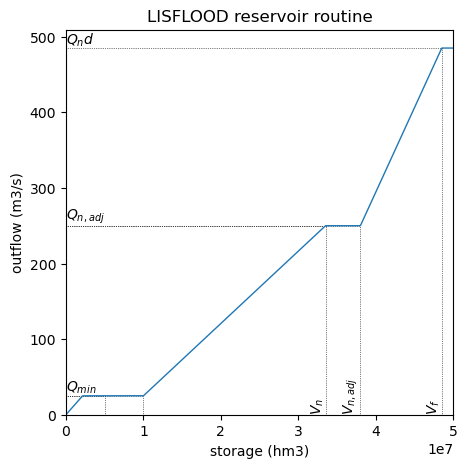

In [19]:
# dummy values
Vtot = 5e7
Qmax = 500
par_Qn = 1
par_Vn = .3

# volume limits (m3)
Vc = .1 * Vtot
Vn = .67 * Vtot
Vf = .97 * Vtot
Vn_adj = Vn + par_Vn * (Vf - Vn)

# outflow limits (m3/s)

Qmin = .05 * Qmax
Qn = .5 * par_Qn * Qmax
Qnd = .97 * Qmax

# declare the reservoir
dummy_lf = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

# plot dummy routine
dummy_lf.plot_routine()

The LISFLOOD reservoir routine is a polyline with three/four rising limbs and three/two plateaus. The calibration only affects the width and height of the second plateau, i.e., the range of reservoir storage ($Q_n$, $Q_{n,adj}$) for which there is a constant release ($Q_{n,adj}$).

**Questions:**
* What's the use of the `Vc` value if then it is always multiplied by 2? Couldn't this multiplication be avoided and consider `Vc` as the 20% of the total capacity?
* What's the purpose of the plateau at `Qn`?

#### Real reservoir

Now I will repeat the analysis with a reservoir from GloFAS. First, I will plot the reference routine given the attributes of this reservoir in GloFAS.

In [20]:
# data = pd.concat((glofas_ts[ResID][['inflow']], resops_ts[ResID][['outflow', 'storage']]), axis=1)
# data[['inflow', 'outflow']] = data[['inflow', 'outflow']].round(2)
# data['storage'] = data['storage'].astype(int)

# data.to_csv(f'E:/casadje/GitHub/spotpy/src/spotpy/examples/reservoirs/input_{ResID:03}.csv')

In [21]:
reservoirs.columns

Index(['GLWD_ID', 'GRAND_ID', 'Source', 'LAKE_NAME', 'DAM_NAME', 'LONG_DEG',
       'LAT_DEG', 'LONG_OUTLE', 'LAT_OUTLET', 'VOLUME_Gra', 'VOL_SRC',
       'COUNTRY', 'SEC_CNTRY', 'RIVER', 'NEAR_CITY', 'DAM_YEAR', 'note',
       'X_coord', 'Y_coord', 'X_CORRECT', 'Y_CORRECT', 'LisfloodX3',
       'LisfloodY3', 'remap_com', 'clim', 'flim', 'minq', 'ndq', 'nlim',
       'normq', 'CAP_GLWD', 'geometry', 'adjustNormalFlood',
       'ReservoirRnormqMult', 'nlim_adj', 'normq_adj', 'CAP_GRAND',
       'CAP_RESOPS', 'CAP'],
      dtype='object')

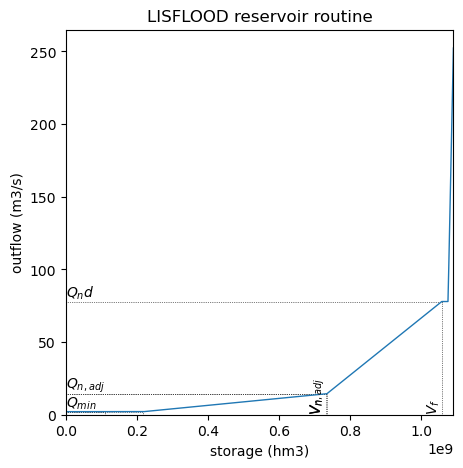

In [22]:
# GloFAS reservoir
ResID = 146 #302 #273 #236 #227

# storage limits
Vc, Vn, Vn_adj, Vf, Vtot = reservoirs.loc[ResID, ['clim', 'nlim', 'nlim_adj', 'flim', 'CAP']]
Vtot *= 1e6
Vc, Vn, Vn_adj, Vf = np.array([Vc, Vn, Vn_adj, Vf]) * Vtot

# outflow limits
Qmin, Qn, Qnd = reservoirs.loc[ResID, ['minq', 'normq_adj', 'ndq']]

# declare the reservoir
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

# plot dummy routine
res.plot_routine()

##### Simulation

Now I will use the observed (ResOpsUS) and simulated (GloFAS4) inflow to the reservoir to simulate the evolution of both the reservoir storage and outflow with the LISFLOOD routine.

In [23]:
# observed and LISFLOOD simulated time series
obs = resops_ts[ResID][['storage', 'inflow', 'outflow']]
sim = glofas_ts[ResID][['storage', 'inflow', 'outflow']]

**LISFLOOD routine according to the documentation**

  0%|          | 0/13878 [00:00<?, ?it/s]

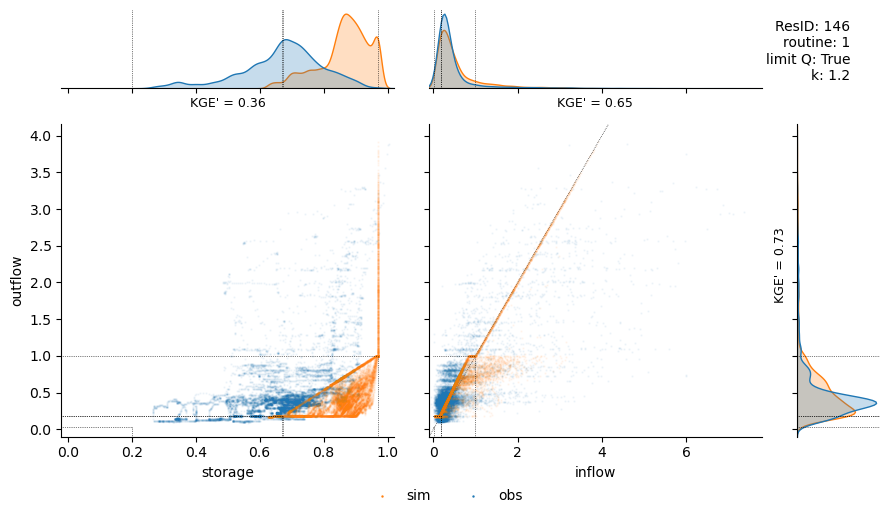

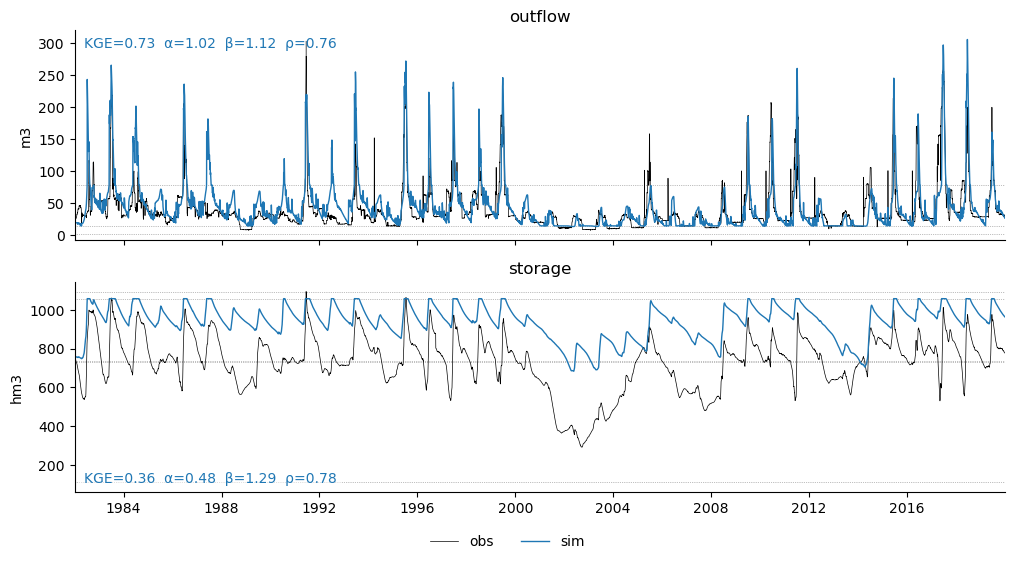

In [25]:
routine = 1
limit_Q = True
k = 1.2

# simulate the reservoir
sim1_12 = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim1_12, 
            obs,
            title=f'ResID: {ResID}\nroutine: {routine}\nlimit Q: {limit_Q}\nk: {k}')

res.lineplot({'sim': sim1_12}, obs, figsize=(12, 6))

The plot above represents the LISFLOOD routine according to the documentation.
* In the flood storage zone ($V_{n,adj} \lt V \le V_f$) the outflow is at most 1.2 times the inflow.
* In the freeboard zone ($V \gt V_f$) the outflow is at most th e inflow with no limit. This lack of limitation causes in this specific reservoir outflows 4 times larger than the non-damaging outflow. The **storage never exceeds $V_f$**, since the outflow in this zone is at least that necessary to return the reservoir to $V_f$; this is the reason why the outflow is never larger than the inflow.

**Effect of k**

  0%|          | 0/13878 [00:00<?, ?it/s]

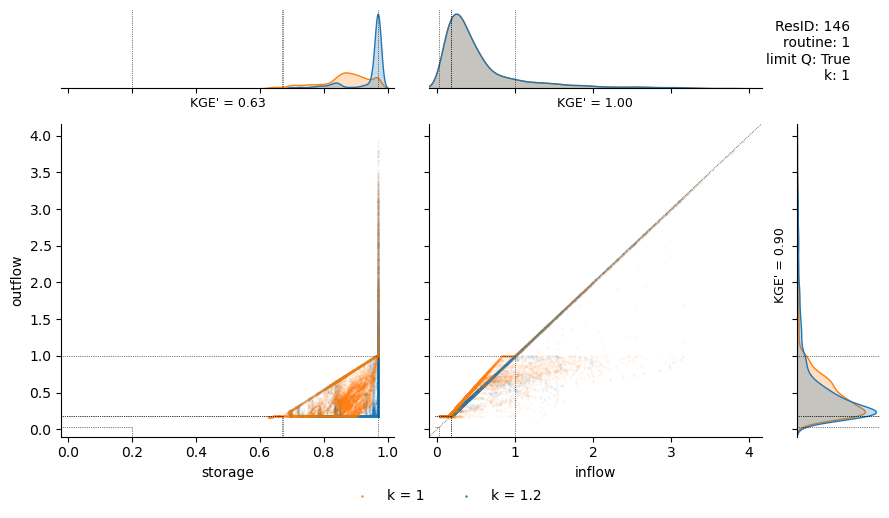

In [26]:
routine = 1
limit_Q = True
k = 1

# simulate the reservoir
sim1_1 = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim1_12, 
            sim1_1,
            title=f'ResID: {ResID}\nroutine: {routine}\nlimit Q: {limit_Q}\nk: {k}',
            labels=['k = 1', 'k = 1.2'])
res.lineplot({'k = 1.2': sim1_12, 'k = 1': sim1_1}, obs, figsize=(12, 6))

The plot above represents the LISFLOOD routine if the $k$ coefficient takes a value of 1 instead of 1.2.
* In the flood zone the outflow is often $Q_n$ (lower than the inflow), so the reservoir tends to fill up to $V_f$. Then, as explained before, the storage can never exceeds $V_f$, so the reservoir storage is mostly equal to $V_f$, which is not correct.

**To limit or not to limit**

  0%|          | 0/13878 [00:00<?, ?it/s]

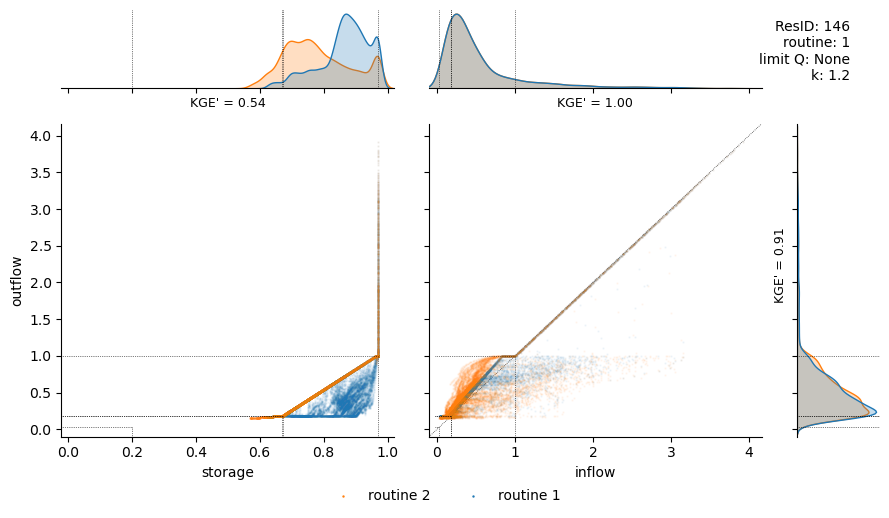

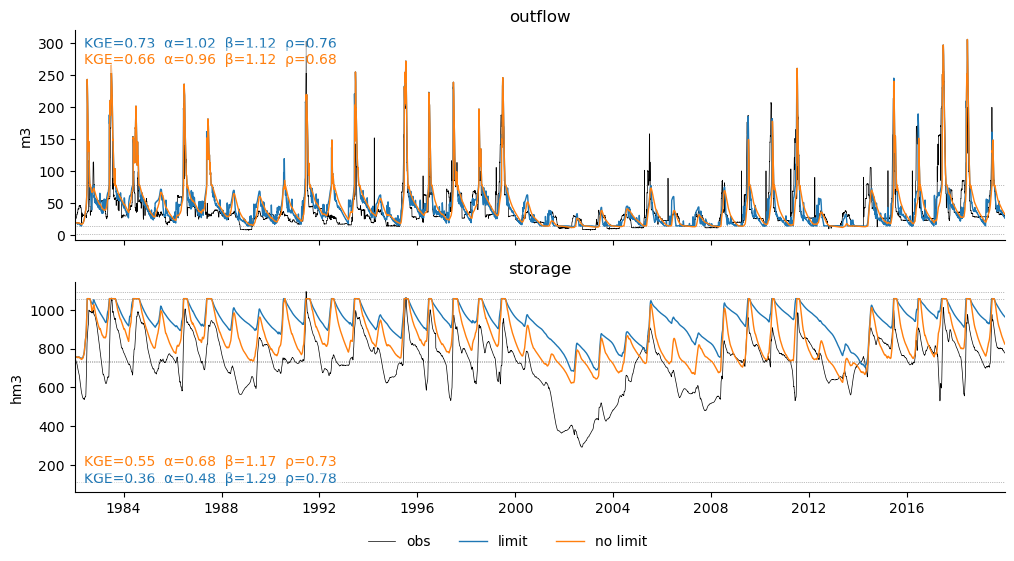

In [28]:
routine = 1
limit_Q = None
k = 1.2

# simulate the reservoir
sim1_nolimit = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim1_nolimit, 
            sim1_12,
            title=f'ResID: {ResID}\nroutine: {routine}\nlimit Q: {limit_Q}\nk: {k}',
            labels=['routine 2', 'routine 1'])

res.lineplot({'limit': sim1_12, 'no limit': sim1_nolimit}, obs, figsize=(12, 6))

  0%|          | 0/13878 [00:00<?, ?it/s]

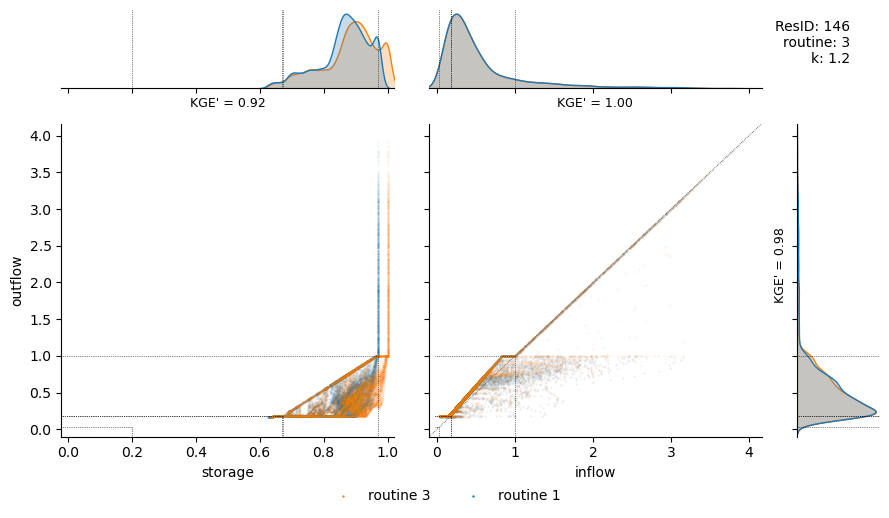

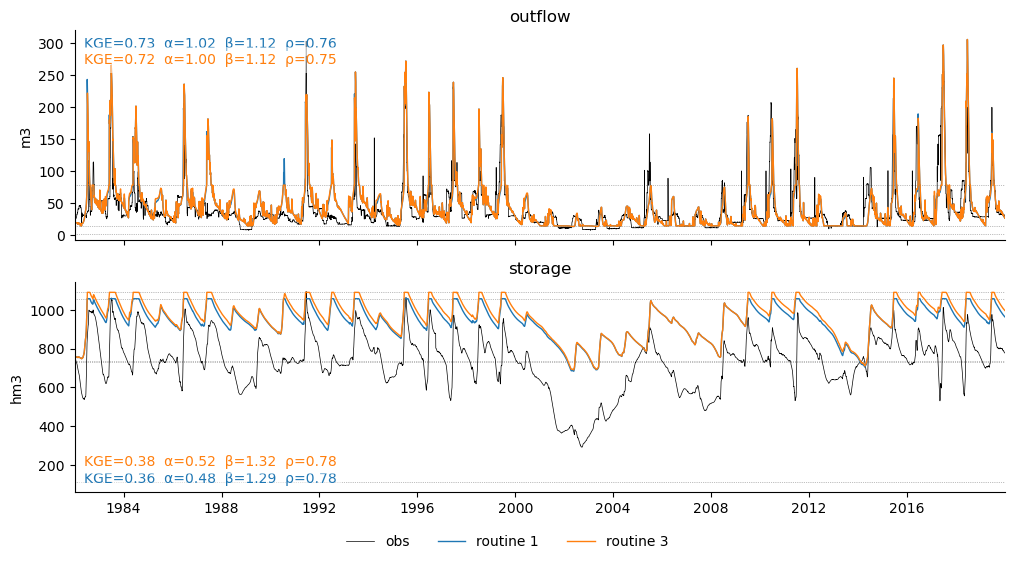

In [ ]:
routine = 3
limit_Q = True
k = 1.2

# simulate the reservoir
sim3 = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim3, 
            sim1_12,
            title=f'ResID: {ResID}\nroutine: {routine}\nk: {k}',
            labels=['routine 3', 'routine 1'])

res.lineplot({'routine 1': sim1_12, 'routine 3': sim3}, obs, figsize=(12, 6))

The routine above limits the outflow in the freeboard zone to the minimum between $Q_{nd}$ and $k \cdot I$. The result is that storage sometimes exceeds $V_f$ (it reaches the full capacity) and that there's a horizontal line at $Q_{nd}$ when $V_f$ is exceeded.

  0%|          | 0/13878 [00:00<?, ?it/s]

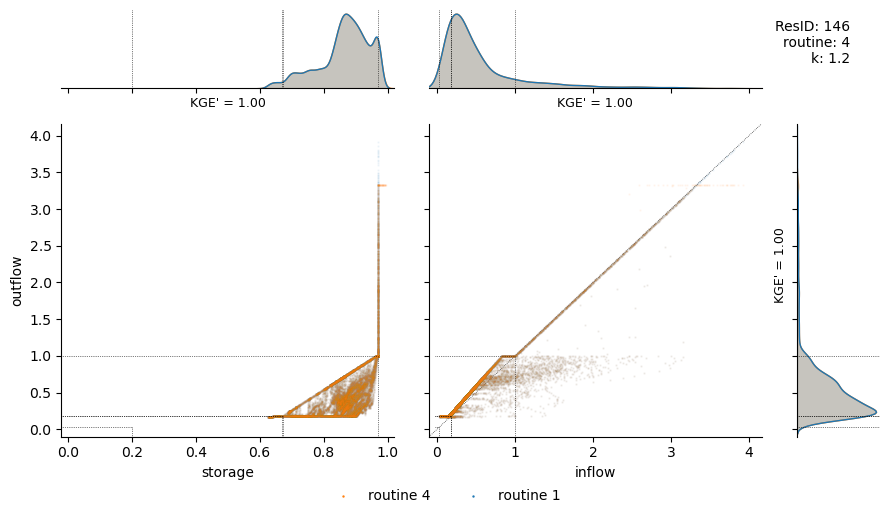

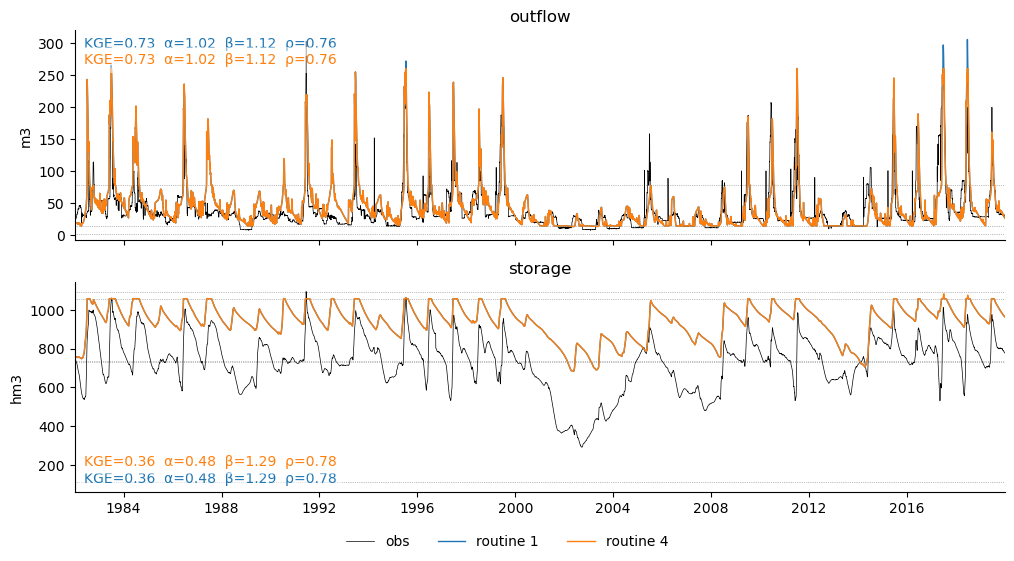

In [30]:
routine = 4
limit_Q = True
k = 1.2

# simulate the reservoir
sim4 = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim4, 
            sim1_12,
            title=f'ResID: {ResID}\nroutine: {routine}\nk: {k}',
            labels=['routine 4', 'routine 1'])
res.lineplot({'routine 1': sim1_12, 'routine 4': sim4}, obs, figsize=(12, 6))

The routine above limits the maximum outflow to a factor of $Q_{nd}$ (3.33 in this example). The result is that the reservoir can exceed $V_f$ when the inflow is larger than $3.33 \cdot Q_{nd}$.

  0%|          | 0/13878 [00:00<?, ?it/s]

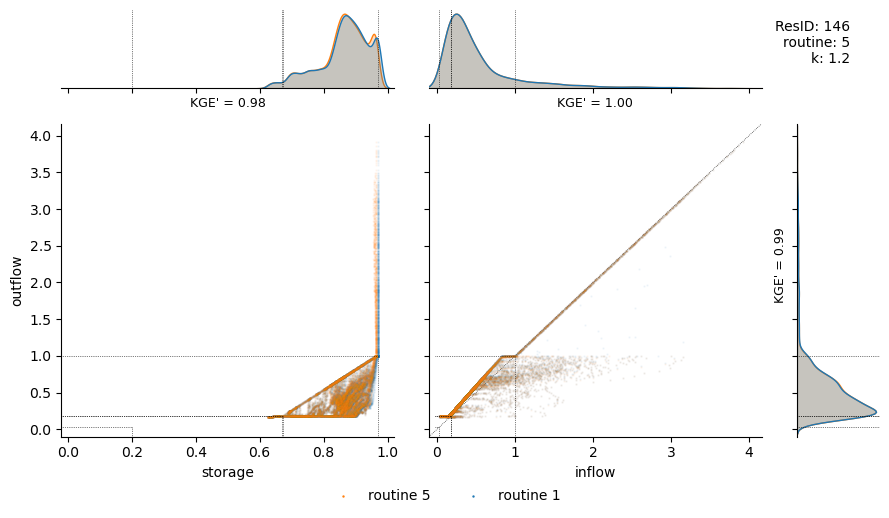

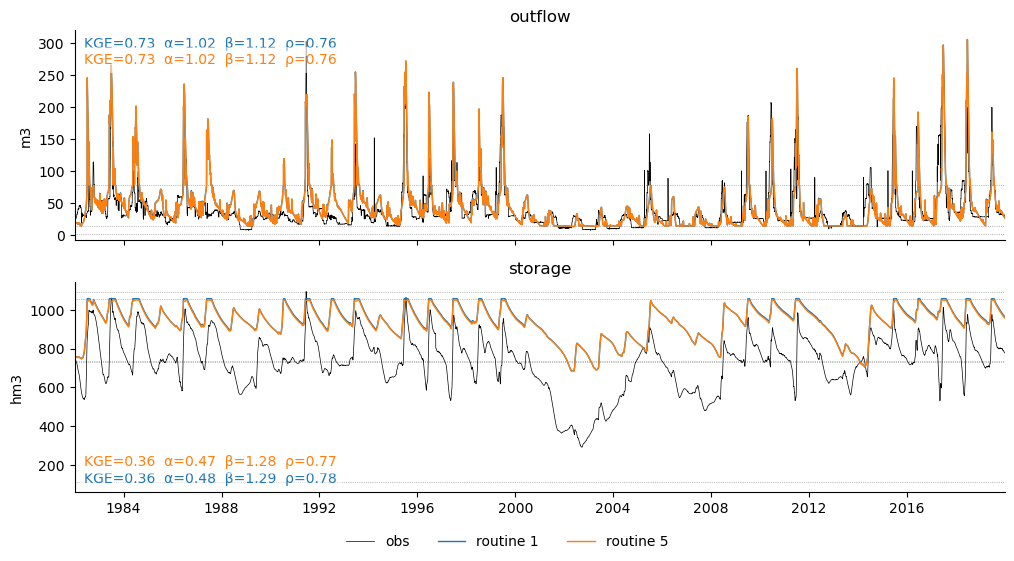

In [31]:
routine = 5
limit_Q = True
k = 1.2

# simulate the reservoir
sim5 = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim5, 
            sim1_12,
            title=f'ResID: {ResID}\nroutine: {routine}\nk: {k}',
            labels=['routine 5', 'routine 1'])

res.lineplot({'routine 1': sim1_12, 'routine 5': sim5}, obs, figsize=(12, 6))

Routine 5 is the simplest. The outflow above $V_f$ is the maximum between $Q_{nd}$ and the inflow.This routine does not limit the maximum outflow (it will be as high as the inflow), and it also causes that the storage never exceeds $V_f$.

  0%|          | 0/13878 [00:00<?, ?it/s]

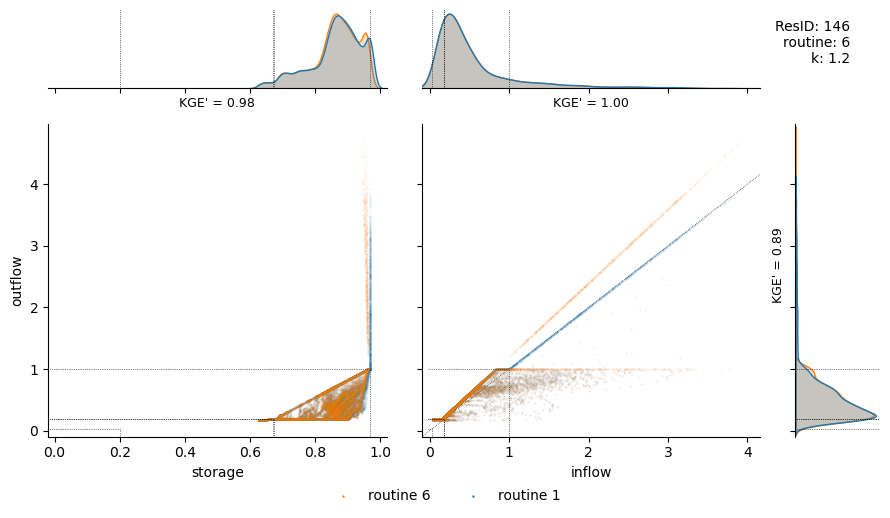

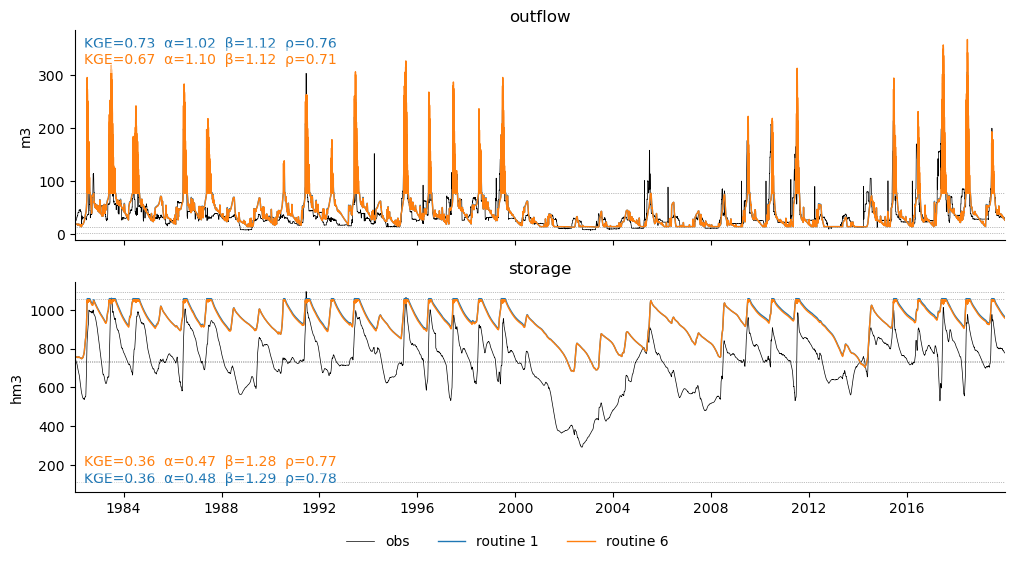

In [32]:
routine = 6
limit_Q = True
k = 1.2

# simulate the reservoir
sim6 = res.simulate(sim.inflow, obs.storage[0], routine=routine, limit_Q=limit_Q, k=k)

# analyse simulation
res.scatter(sim6, 
            sim1_12,
            title=f'ResID: {ResID}\nroutine: {routine}\nk: {k}',
            labels=['routine 6', 'routine 1'])
res.lineplot({'routine 1': sim1_12, 'routine 6': sim6}, obs, figsize=(12, 6))

Routine 6 defines the outflow in the freeboard zone depending on whether it is the rising or falling limb of the hydrograph. In the rising limb the outflow is forced to be lower than the inflow (so it buffers the flood peak), and in the falling limb it allows for outflows larger than the inflow (to return into normal storage conditions).

The result is that storage reaches the total capacity in some time steps.

>**Note**. The routine should be improved, because the outflow should only be larger than the inflow once the peak outflow is reached. In the current implementation, as soon as the inflow hydrograph decreases the outflow can exceed inflow.

**Simulation using as inflow the ResOpsUS records**

When using the observed inflow as input, the simulated outflow has a very good performance ($KGE=0.71$), but all the loss in performance must be attributed to the reservoir routine, which means that there's ground for improvement. 

Ideas for improvement:
* The outflow distribution function shows two modes related to the normal and the flood outflows. These two values correspond to the plateaus in the routine. Do they make any sense?
* The storage limits are completely deviated from the observation. The reservoir tends to be almost full, when in reality the reservoir is mostly between 60-80% filling. Can we fit the storage limits based on records (when available) and regionalize these values to reservoirs that lack observations?

> **None**. What if I tune the reservoir parameters of the LISFLOOD routine. Can I improve at the same time the performance in the simulation of storage and outflow? The following step would be to calibrate the reservoir with two target variables: outflow and storage.

**Rerun with customize parameters**

Below I will set a new instance of the same reservoir but with storage and outflow limits that I have selected. As a first approach I will set them based on the limits used in the Hanazaki model, which are computed from observed data.

Storage limits:

* $V_{n,adj}$ will be the storage value with the highest density in the KDE.
* $V_n$ will be a fraction of $V_{n,adj}$. I will test two options:
    * $V_n = V_{n,adj}$, which removes the horizontal line at $Q_n$ in the reference routine.
    * $V_n = 0.5 \cdot V_{n,adj}$.
* $V_f$ will be the 80% storage between $V_{n,adj}$ and $V_{tot}$.

Outflow limits:

* $Q_n$ is the outflow value with the highest density in the observed time series.
* $Q_{nd}$ is the 30% of the peak discharge of 100 year return period.
* $Q_{min}$ is the annual average of the discharge that is not exceeded 5% of the time.
* The release coefficient $k$ will be 2, to avoid an excessive regulation.

In [33]:
routine = 5
k = 1.2

# storage limits
# Vn_adj = obs.storage.quantile(.75)
Vn_adj = get_normal_value(obs.storage) 
# Vn = 0.5 * Vn_adj
Vn = 1 * Vn_adj
Vtot = reservoirs.loc[ResID, 'CAP'] * 1e6
Vf = Vtot - .2 * (Vtot - Vn_adj)

# outflow limits
# Qn = obs.inflow.median()
Qn = get_normal_value(obs.outflow) 
#Qnd = obs.inflow.quantile(.99)
Q100 = return_period(sim.inflow, T=100)
Qnd = .3 * Q100
Qmin = obs.inflow.groupby(obs.index.year).quantile(.05).mean()

# instantiate the reservoir
res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

# simulate the reservoir
sim_aux = res.simulate(sim.inflow, obs.storage[0], routine=5, k=k)

  0%|          | 0/13878 [00:00<?, ?it/s]

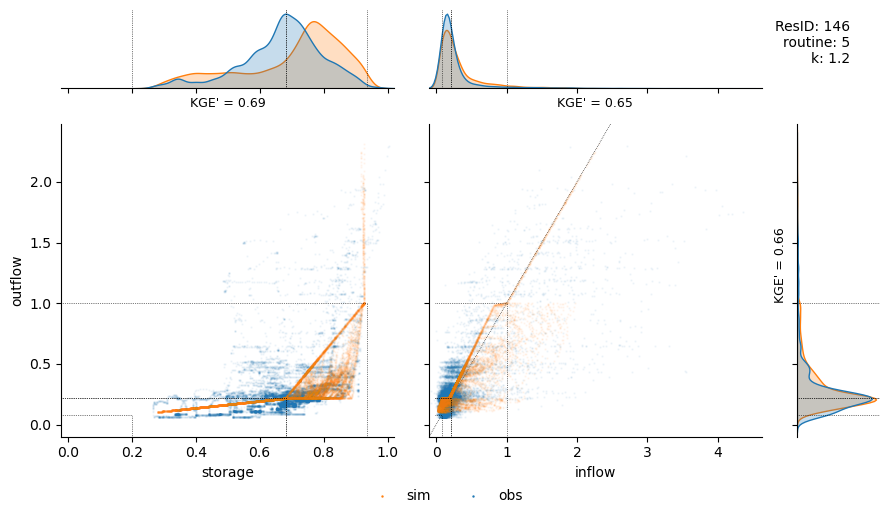

In [34]:
# analyse simulation
res.scatter(sim_aux, obs, title=f'ResID: {ResID}\nroutine: {routine}\nk: {k}')

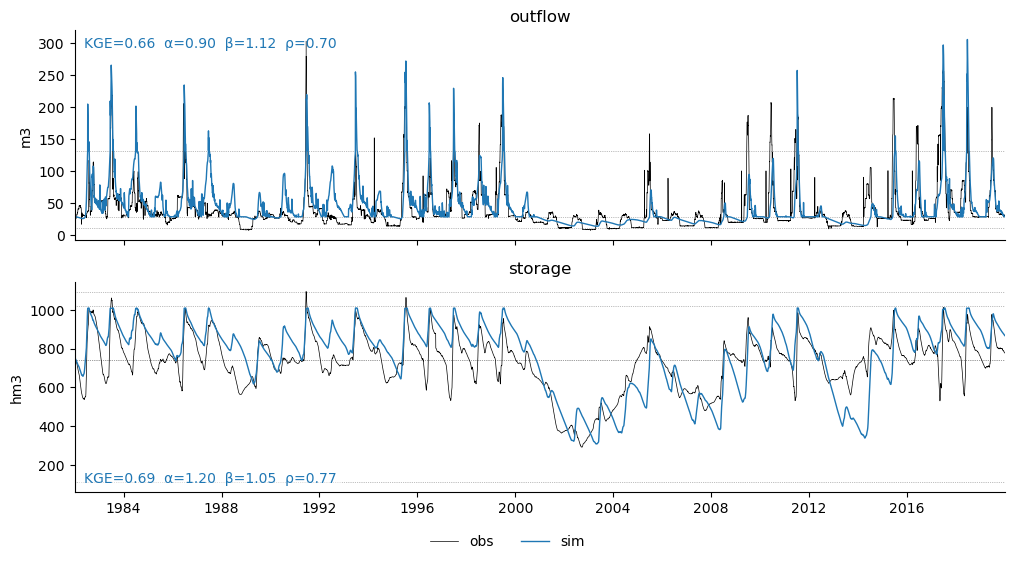

In [35]:
res.lineplot({'sim': sim_aux}, obs, figsize=(12, 6))

  0%|          | 0/13878 [00:00<?, ?it/s]

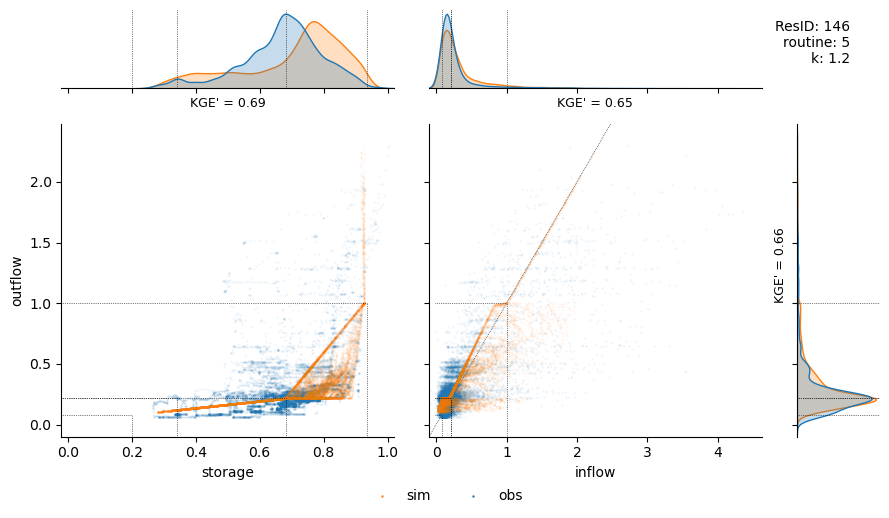

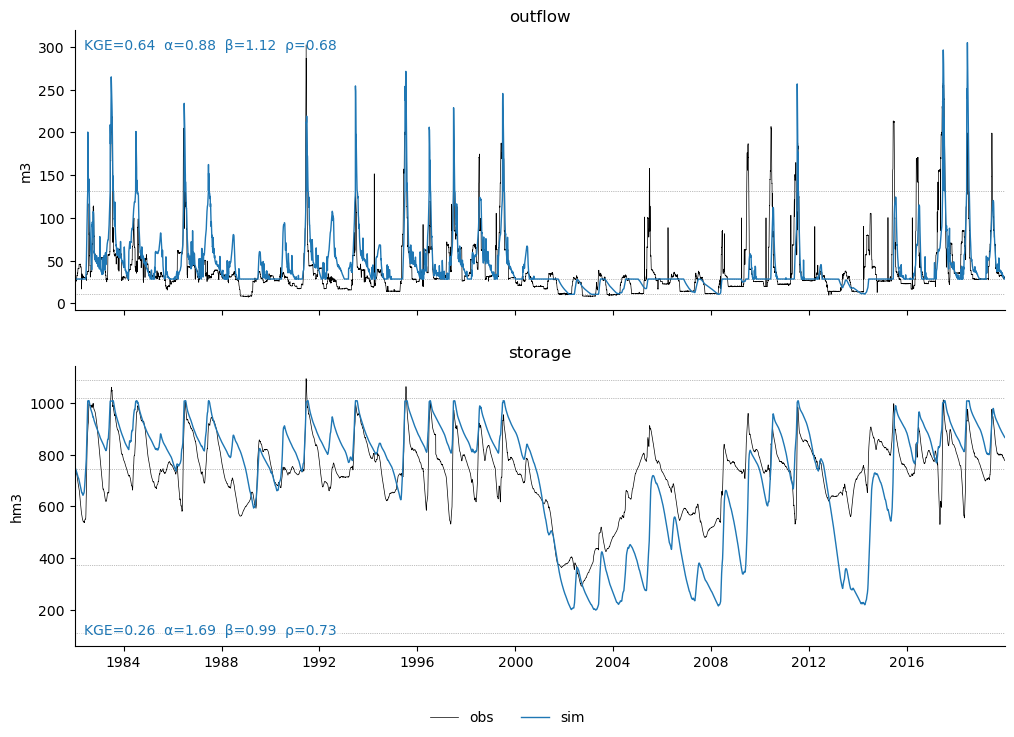

In [36]:
# instantiate the reservoir
res_ = Lisflood(Vc, 0.5 * Vn_adj, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

# simulate the reservoir
sim_ = res_.simulate(sim.inflow, obs.storage[0], routine=5, k=k)

# analyse simulation
res_.scatter(sim_aux, obs, title=f'ResID: {ResID}\nroutine: {routine}\nk: {k}')

res_.lineplot({'sim': sim_}, obs)

The routine forces the reservoir storage to be close to the flood limit, because the outflow is limited by this clause in the routine:

```Python
# limit outflow depending on the inflow
if (Q > 1.2 * I) & (Q > self.Qn) & (V < self.Vf):
    Q = np.min([Q, np.max([I, self.Qn])])
```

The effect of this clause can be seen in both scatter plots. On the left, it causes the outflows below the reference routine between 0.5 and 0.8 storage; the result is that the peak in the outflow densitiy function shifts towards the normal release ($Q_{n}$). On the right plot, it causes that the inflow-outflow relationship follows mostly the 1-1 relationship, which means that **the reservoir has no regulation capacity**.

I have implemented a switch to this clause (attribute `limit_Q` in the method `simulate`) to test how the routine would work if there wouldn't be such limitation. I have also added a release coefficient (`k`) so that, in the case of applying the limitation, avoids constant outflows at $Q_{n}$. The previous snippet is now:

```Python
# limit outflow depending on the inflow
elif V < self.Vf:
    Q = self.Qn + (self.Qnd - self.Qn) * (V - self.Vn_adj) / (self.Vf - self.Vn_adj)
    if limit_Q:
        if Q > k * I:
            Q = np.max([k * I, self.Qn])
```

Below the results:

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

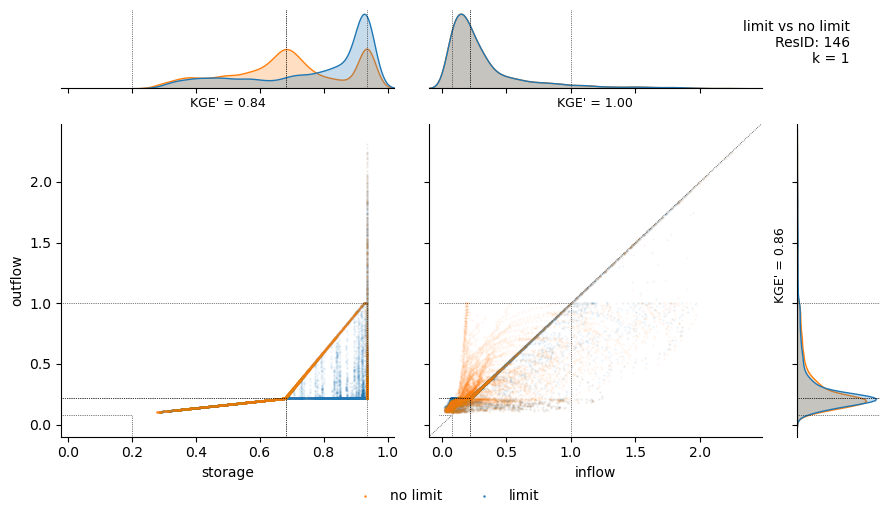

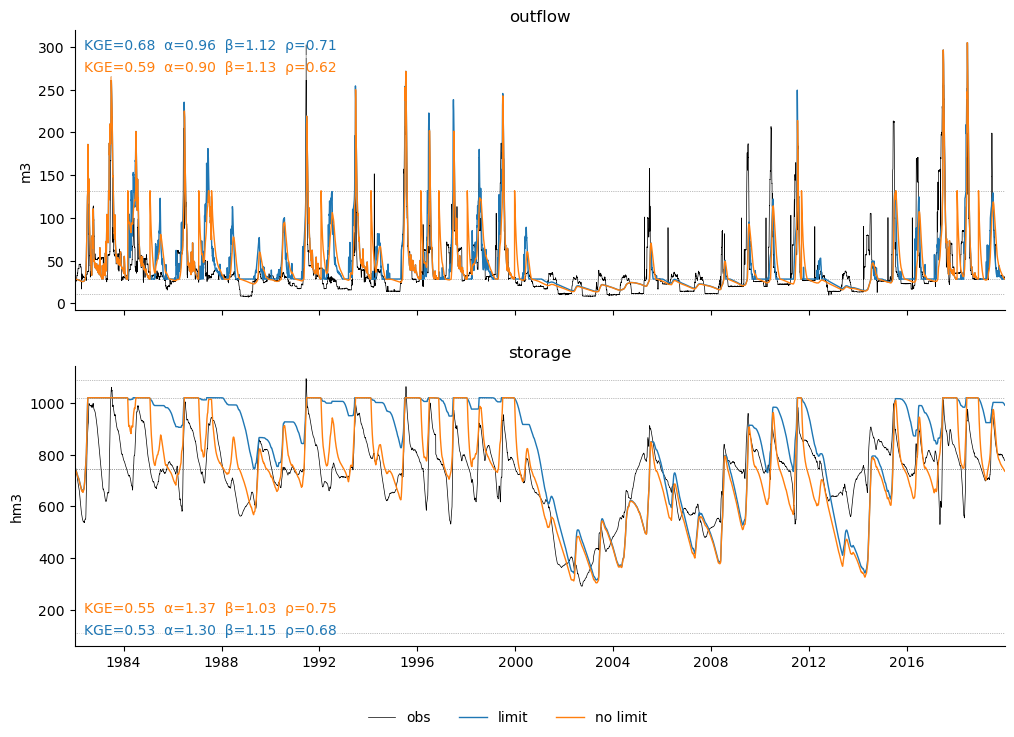

In [39]:
# instantiate the reservoir
model = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

k = 1

# simulate the reservoir
nolimit = model.simulate(sim.inflow, obs.storage[0], limit_Q=False, k=k)
# simulate the reservoir
limit = model.simulate(sim.inflow, obs.storage[0], limit_Q=True, k=k)

# analyse simuation
model.scatter(nolimit, limit,
              labels=['no limit', 'limit'],
              title=f'limit vs no limit\nResID: {ResID}\nk = {k}')
model.lineplot({'limit': limit, 'no limit': nolimit}, obs)

When the limitation is removed (`limit_Q=False`), the results of the reservoir simulation change significantly. On the storage-outflow plot, the simulation follows almost perfectly the reference routine; there's been a shift in the distribution of storage from values close to $V_f$ to values close to $V_{n,adj}$; the outflow is not limited by inflow, so they are higher and, hence, the storage is lower. On the inflow-outflow plot, there is a lot of scatter, with a majority of points below the 1-1 line (the reservoir stores water), but a high density of points above the 1-1 line for lower inflow (the reservoir empties); still, there's an excess of outflows at $Q_{n}$.

  0%|          | 0/13878 [00:00<?, ?it/s]

  0%|          | 0/13878 [00:00<?, ?it/s]

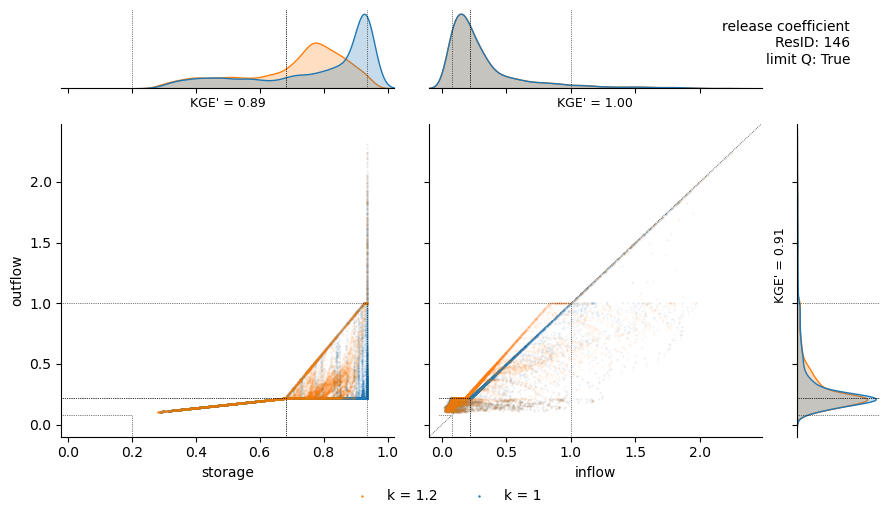

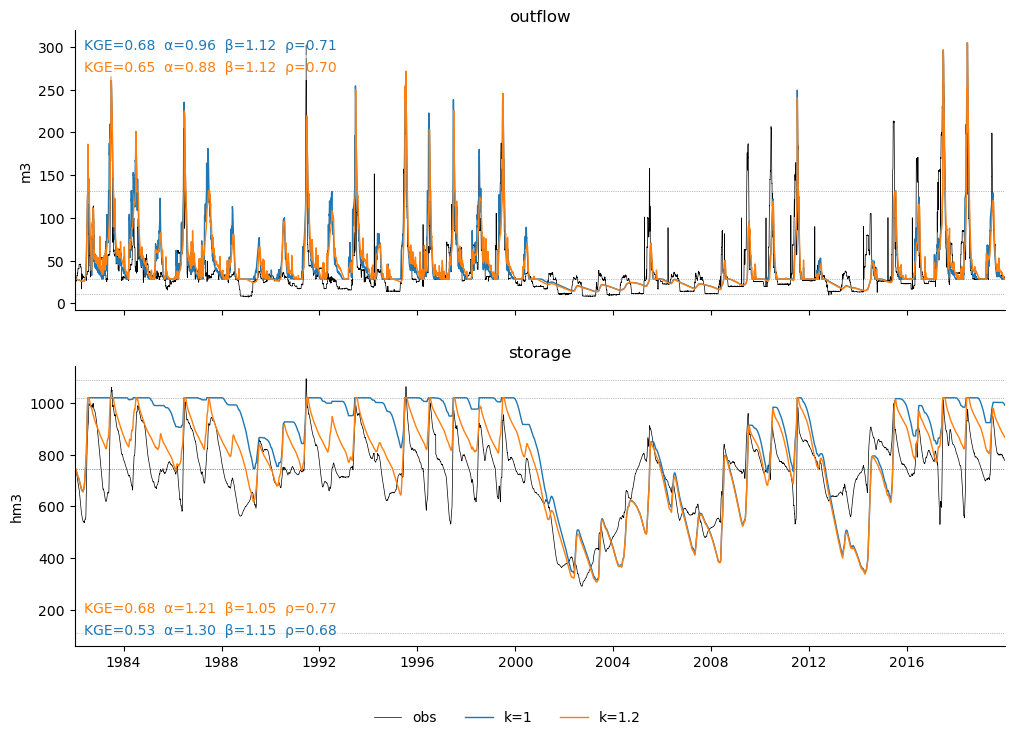

In [40]:
limit_Q = True
k = [1, 1.2]

# simulate the reservoir
k1 = model.simulate(sim.inflow, obs.storage[0], limit_Q=limit_Q, k=k[0])
# simulate the reservoir
k2 = model.simulate(sim.inflow, obs.storage[0], limit_Q=limit_Q, k=k[1])

model.scatter(k2, k1,
              labels=[f'k = {x}' for x in k[::-1]],
              title=f'release coefficient\nResID: {ResID}\nlimit Q: {limit_Q}')
model.lineplot({f'k={k[0]}': k1, f'k={k[1]}': k2}, obs)

The plot above shows the difference when the outflow limitation is kept (`limit_Q=True`), but the release coefficient varies.
* In the storage-outflow plot, the lower the $k$ coefficient, the more prone the reservoir would be to limit the outflow to $Q_n$ and fill up until $V_f$. The storage density plot with $k = 1$ approaches $V_f$, whereas that for $k = 1.2$ approaches $V_n$.
* In the inflow-outflow plot it is more clear the effect of $k$ on the reservoir behaviour. $k$ controles the slope of the line on which the pairs inflow-outflow accumulate. The higher $k$, the larger the releases, and so the emptier the reservoir.

When the limitation is kept (`limit_Q=True`), but a release coefficient is set (`k=1.2`), the results are in between the previous two options. The storage-outflow does not follo strictly the reference routine, but there is a shift in the storage distribution towards $Q_{n,adj}$. In the inflow-outflow plot there is a high density of points that follow a line with slope $k$; however, there's some dispersion below that line; still, the mode of the outflow is close to $Q_{n}$.

### Simulate all reservoirs

In [ ]:
path_lisflood = Path('../results/reservoirs/LISFLOOD')
path_plots = path_lisflood / 'behaviour'
for path in [path_lisflood, path_plots]:
    if path.exists() is False:
        path.mkdir()

In [ ]:
routine = 5
k = 2
limit_Q = True

lisflood_res = {}
lisflood_ts = {}
for ResID in tqdm(reservoirs.index):
    
    # observed and LISFLOOD simulated time series
    obs = resops_ts[ResID][['storage', 'inflow', 'outflow']]
    start = obs.storage.first_valid_index()
    sim_lf = glofas_ts[ResID][['storage', 'inflow', 'outflow']]
    
    # storage limits
    Vn_adj = get_normal_value(obs.storage) 
    Vn = 1 * Vn_adj
    Vtot = reservoirs.loc[ResID, 'CAP'] * 1e6
    Vf = Vtot - .2 * (Vtot - Vn_adj)

    # outflow limits
    if obs.outflow.isnull().all():
        Qn = reservoirs.loc[ResID, 'normq_adj']
    else:
        Qn = get_normal_value(obs.outflow) 
    if obs.inflow.isnull().all():
        Qmin, Qnd = Qmin, Qnd = reservoirs.loc[ResID, ['minq', 'ndq']]
    else:
        Q100 = return_period(obs.inflow, T=100)
        Qnd = .3 * Q100
        Qmin = obs.inflow.groupby(obs.index.year).quantile(.05).mean()
    Qmin = np.min([Qmin, Qn])

#     # storage limits (m3)
#     Vc, Vn, Vn_adj, Vf, Vtot = reservoirs.loc[ResID, ['clim', 'nlim', 'nlim_adj', 'flim', 'CAP']]
#     Vtot *= 1e6
#     Vc, Vn, Vn_adj, Vf = np.array([Vc, Vn, Vn_adj, Vf]) * Vtot

#     # outflow limits (m3/s)
#     Qmin, Qn, Qnd = reservoirs.loc[ResID, ['minq', 'normq_adj', 'ndq']]

    # declare the reservoir
    res = Lisflood(Vc, Vn, Vn_adj, Vf, Vtot, Qmin, Qn, Qnd)

    # simulate the reservoir
    sim = res.simulate(sim_lf.inflow[start:], obs.storage[start], routine=routine, limit_Q=limit_Q, k=k)

    try:
        # analyse simuation
        res.compare(sim,
                    obs,
                    alpha=.1,
                    title=f'ResID: {ResID}\nroutine: {routine}\nQlimit: {limit_Q} \nk: {k}',
                    save=path_plots / f'{ResID:03}.jpg')
    except:
        print(ResID)
        continue
        
    # organize results
    lisflood_res[ResID] = res
    lisflood_ts[ResID] = sim

In [ ]:
# export simulated time series
path_ts = path_lisflood / 'timeseries'
if path_ts.exists() is False:
    path_ts.mkdir()
for ResID, ts in tqdm(lisflood_ts.items()):
    ts.to_csv(path_ts / f'{ResID:03}.csv', float_format='%.3f')

#### Performance

In [ ]:
Performance_glofas = {}
for var in ['storage', 'inflow', 'outflow']:
           
    # compute performance
    performance = pd.DataFrame(index=reservoirs.index, columns=['KGE', 'alpha', 'beta', 'r'], dtype=float)
    for id in tqdm(performance.index):
        if (id in resops_ts) & (id in glofas_ts):
            obs, sim = resops_ts[id][var], glofas_ts[id][var]
            if obs.isnull().all() or sim.isnull().all():
                continue
            performance.loc[id,:] = KGEmod(obs, sim)
    Performance_glofas[var] = performance
    print('no. reservoirs with {0} data:\t{1}'.format(var, performance.dropna(axis=0).shape[0]))

In [ ]:
Performance_lisflood = {}
for var in ['storage', 'inflow', 'outflow']:
    
    # output path
    path_var = path_lisflood / var
    if path_var.exists() is False:
        path_var.mkdir()
        
    # compute performance
    performance = pd.DataFrame(index=reservoirs.index, columns=['KGE', 'alpha', 'beta', 'r'], dtype=float)
    for id in tqdm(performance.index):
        if (id in resops_ts) & (id in lisflood_ts):
            obs, sim = resops_ts[id][var], lisflood_ts[id][var]
            if obs.isnull().all() or sim.isnull().all():
                continue
            performance.loc[id,:] = KGEmod(obs, sim)
    Performance_lisflood[var] = performance
    print('no. reservoirs with {0} data:\t{1}'.format(var, performance.dropna(axis=0).shape[0]))
    
    # performance maps
    title = f'LISFLOOD performance in simulating {var}'
    file = path_var / 'maps_performance.jpg'
    maps_performance(reservoirs.geometry.x, reservoirs.geometry.y, performance, s=reservoirs.CAP**.5,
                     extent=extent, title=title, save=file)

### Reservoir behaviour

In [ ]:
var = 'behaviour'
path_var = path_lisflood / var
if path_var.exists() is False:
    path_var.mkdir()

#### Compare performance

In [ ]:
Performance = {'GloFAS': Performance_glofas,
               'LISFLOOD': Performance_lisflood}

In [ ]:
fig, ax = plt.subplots(figsize=(4, 4))

for (model, dct), ls in zip(Performance.items(), [':', '-']):
    for (var, df), c in zip(dct.items(), ['steelblue', 'forestgreen', 'darkred']):
        if var == 'inflow':
            continue
        ecdf = ECDF(df['KGE'], plot=False)
        ecdf.plot(ax=ax, c=c, ls=ls, label=f'{var} {model}')
        
ax.set(ylim=(-1.02, 1.02),
       xlim=(-.01, 1.01),
       xlabel='ECDF (-)',
       ylabel='KGE (-)')
fig.legend(frameon=False, loc=1, bbox_to_anchor=[1.175, .5, .2, .4]);

The performance of the LISFLOOD routine when the outflow limit is removed is similar to the original routine. There is a minor loss in KGE in the reservoir outflow, but the storage outperforms clearly the original routine.

The performance of the Hanazaki model is very similar, but slighly lower, than GloFAS for the outflow, but it's clearly higher for the reservoir storage. This results contrast with the fact that the reservoirs in GloFAS were calibrated (2 of the parameters in the reservoir routine), whereas in the Hanazaki model I have used directly the specification explained in the article. It is true, though, that the derivation of the Hanazaki reservoir parameters is based on observed storage data, a data to which GloFAS was never exposed.

Apart from the general performance of the reservoir, it is of special interest to analyse the peak discharge. I will compare the peak discharge error ($PDE$) for the GloFAS and Hanazaki simulations:

$$
PDE = \frac{1}{n} \cdot \sum_{i=1}^{n} \left| Q_{i,obs} - Q_{i,sim} \right|
$$

In [ ]:
# peak discharge error
pde = pd.DataFrame(index=list(lisflood_ts), columns=['GloFAS', 'LISFLOOD'])
for ResID in pde.index:
    obs = resops_ts[ResID].outflow
    sim_lf = glofas_ts[ResID].outflow
    sim = lisflood_ts[ResID].outflow
    pde.loc[ResID, 'GloFAS'] = PDE(obs, sim_lf)
    pde.loc[ResID, 'LISFLOOD'] = PDE(obs, sim)
    
    # plot CDFs
    # if obs.isnull().all():
    #     continue
    # fig, ax = plt.subplots(figsize=(4, 4))
    # ax.plot(CDF(obs.dropna()), 'k', label='obs')
    # ax.plot(CDF(sim_lf), 'C0', label='GloFAS')
    # ax.plot(CDF(sim), 'C1', label='LISFLOOD')
    # ax.set(xlim=(0, None),
    #        xlabel='outflow (m3/s)',
    #        ylim=(-.01, 1.01),
    #        ylabel='CDF')
    # ax.legend(frameon=False, loc=4);

In [ ]:
# plot
fig, ax = plt.subplots(figsize=(4, 4))
ax.scatter(pde.GloFAS, pde.LISFLOOD, s=3, alpha=.33)
vmax = 71
ax.plot([-1, vmax], [-1, vmax], '--k', lw=.5, zorder=0)
ax.set(xlim=(-1, vmax),
       xlabel='GloFAS',
       ylim=(-1, vmax),
       ylabel='LISFLOOD',
       title='PDE (-)');

In [ ]:
ResID = 7

In [ ]:
obs = resops_ts[ResID].outflow
sim_lf = glofas_ts[ResID].outflow
sim_hnzk = hanazaki_ts[ResID].outflow

In [ ]:
df = pd.concat((resops_ts[ResID].outflow, glofas_ts[ResID].outflow, hanazaki_ts[ResID].outflow), axis=1)
df.columns = ['obs', 'glofas', 'hanazaki']

In [ ]:
maxima = df.groupby(df.index.year).max()
maxima.head()